In [1]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg'

In [2]:
#from ultralytics import YOLO

In [3]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter
import os
import shutil

In [4]:
import skvideo
import skvideo.io

def load_video(fn):
    videodata = skvideo.io.vread(fn)
    return videodata

In [5]:
def save_video(videodata,ofn='outvideo.mp4'):
    import skvideo
    import skvideo.io
    #skvideo.io.vwrite(ofn, videodata.astype(np.uint8),outputdict={'-codec': 'h264', '-filter:v' : 'fps=29.97'})
    skvideo.io.vwrite(ofn, videodata.astype(np.uint8))

In [6]:
indir = '~/BC-actionpred-seg/Data/haa500_v1_1_frames/video/'
indir = os.path.expanduser(indir)
indir

'/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_frames/video/'

In [8]:
folders = [folder for folder in os.listdir(indir) if not folder.startswith('.')]
folders.sort()
folders[0:5]

['ALS_IceBucket_Challenge',
 'CPR',
 'abseiling',
 'add_new_car_tire',
 'adjusting_glasses']

In [10]:
len(folders)

499

In [11]:
videos = []
for folder in folders:
    conts = os.listdir(os.path.join(indir,folder))
    conts = [os.path.join(indir,folder,cont) for cont in conts if not cont.startswith('.')]
    conts.sort()
    videos.append(conts)

In [12]:
def get_mask_resized(im,mask):
    im2 = Image.fromarray((mask*255).astype(np.uint8)).resize(size=(im.shape[1],im.shape[0]), resample=PIL.Image.NEAREST)
    return np.array(im2)

In [13]:
def cut_to_mask(im,mask):
    im2 = im.copy()
    for c in range(im2.shape[-1]):
        im2[:,:,c][mask==0]=0
        
    return im2

In [14]:
def cut_to_mask_inv(im,mask):
    im2 = im.copy()
    for c in range(im2.shape[-1]):
        im2[:,:,c][mask!=0]=0
        
    return im2

In [18]:
folder = 20
video = 10

In [19]:
print(videos[folder][video])

/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_frames/video/badminton_underswing/badminton_underswing_010


In [20]:
frames_filenames = [frame for frame in os.listdir(videos[folder][video]) if frame.endswith('.png')]
masks_filenames = [mask for mask in os.listdir(videos[folder][video]) if mask.endswith('_masks.npy')]
box_filenames = [box for box in os.listdir(videos[folder][video]) if box.endswith('_box.npy')]

assert len(frames_filenames)==len(masks_filenames),'mismatch'
assert len(frames_filenames)==len(box_filenames),'mismatch'

frames_filenames.sort()
masks_filenames.sort()
box_filenames.sort()

nframes = len(frames_filenames)
nframes

31

In [21]:
frames = [plt.imread(os.path.join(videos[folder][video],frames_filenames[f])) for f in range(nframes)]
masks = [np.load(os.path.join(videos[folder][video],masks_filenames[f])) for f in range(nframes)]
boxes = [np.load(os.path.join(videos[folder][video],box_filenames[f])) for f in range(nframes)]

In [22]:
len(frames)

31

In [23]:
## TODO: BUILD A COMPLEMENT, REMOVING ITEM, KEEPING BACKGROUND

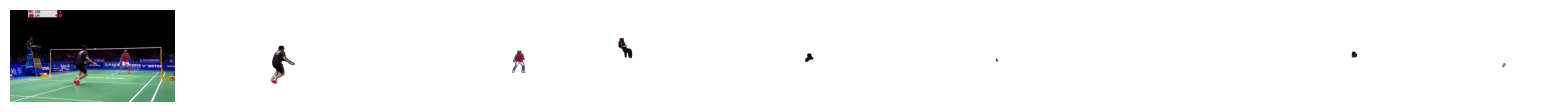

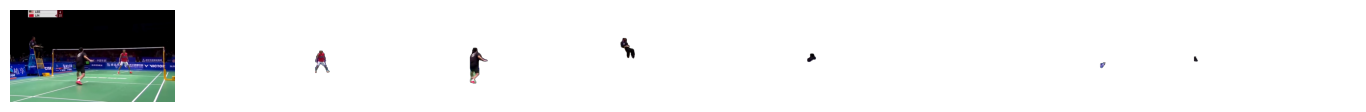

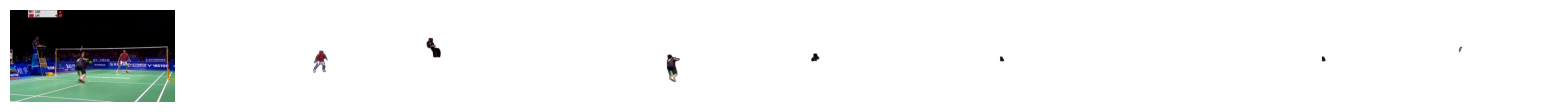

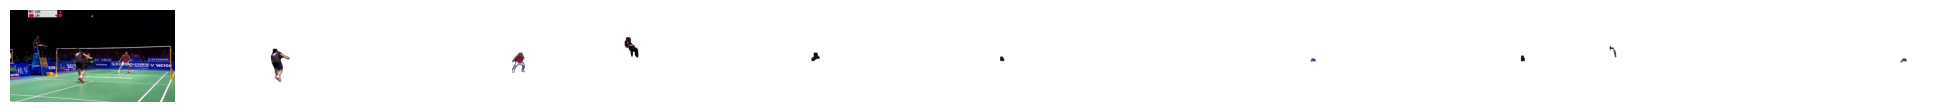

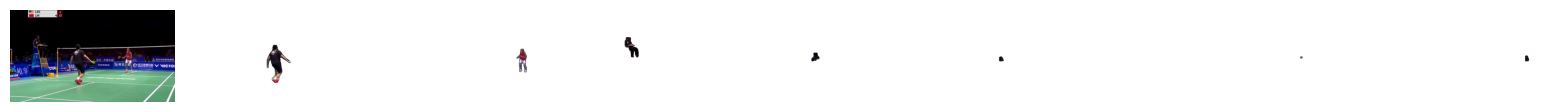

In [24]:
for c,f in enumerate(np.linspace(0,nframes-1,5).astype(int)):
    plt.figure(figsize=((25,5)))
    plt.subplot(1,10,1)
    plt.imshow(frames[f])
    plt.axis('off');

    for i in range(min((masks[f].shape[0],9))):
        plt.subplot(1,10,2+i)
        plt.imshow(cut_to_mask(frames[f],get_mask_resized(frames[f],masks[f][i,:,:])))
        plt.axis('off')

3


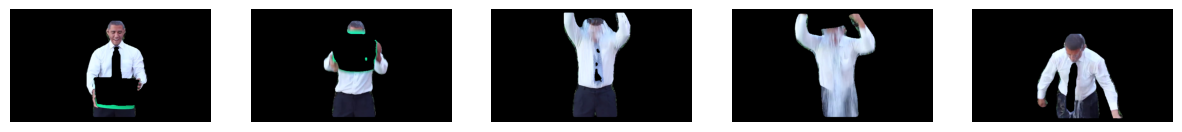

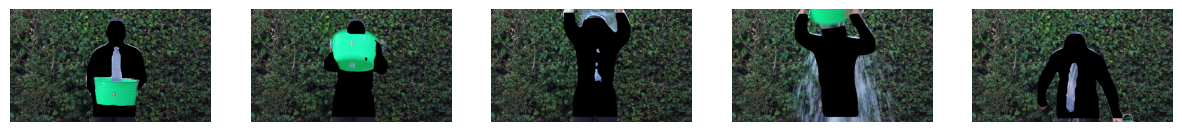

/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_frames/video/ALS_IceBucket_Challenge/ALS_IceBucket_Challenge_000/ALS_IceBucket_Challenge_000_seg_0.mp4


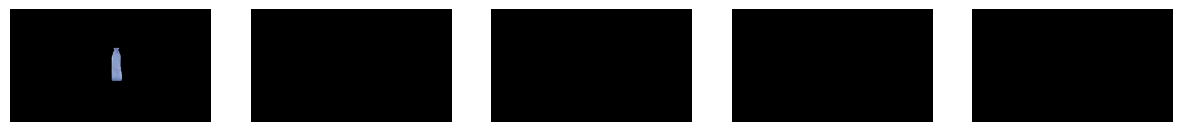

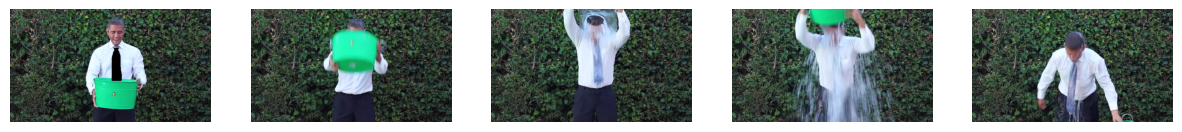

/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_frames/video/ALS_IceBucket_Challenge/ALS_IceBucket_Challenge_000/ALS_IceBucket_Challenge_000_seg_1.mp4


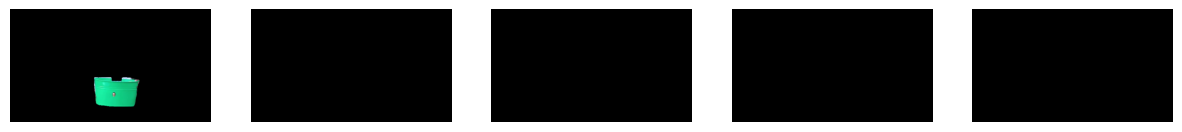

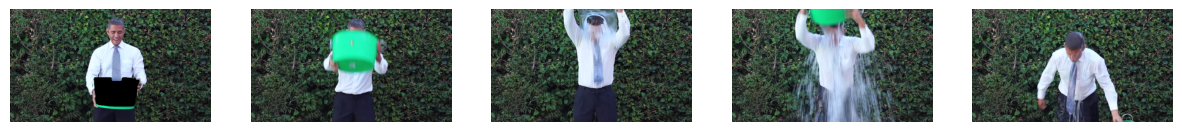

/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_frames/video/ALS_IceBucket_Challenge/ALS_IceBucket_Challenge_000/ALS_IceBucket_Challenge_000_seg_2.mp4
done


In [602]:
these_masks = []
frame_id = 0
#frame = frames[f]
n_items = masks[0].shape[0]
print(n_items)

for this_item in range(n_items):
    mask = masks[0][this_item,:,:]
    these_masks = []
    these_masks.append(mask)
    for j in range(1,nframes):
        mask_sim = np.array([np.corrcoef(masks[j][i,:,:].flatten(),mask.flatten())[0,1] for i in range(masks[j].shape[0])])
        #print(mask_sim)
        if (mask_sim > .5).sum() < 1:
            next_mask = np.zeros(mask.shape)
            mask = next_mask
        else:
            next_mask = masks[j][np.argmax(mask_sim),:,:]
            mask = next_mask

        these_masks.append(mask)

    arr = np.array([cut_to_mask(frames[i],get_mask_resized(frames[i],these_masks[i])) for i in range(len(frames))])
    arr2 = np.array([cut_to_mask_inv(frames[i],get_mask_resized(frames[i],these_masks[i])) for i in range(len(frames))])
    
    plt.figure(figsize=(15,5))
    for c,i in enumerate(np.floor(np.linspace(0,nframes-1,5))):
        plt.subplot(1,5,c+1)
        plt.axis('off')
        plt.imshow(arr[int(i),:,:,0:3])
    plt.show()

    
    plt.figure(figsize=(15,5))
    for c,i in enumerate(np.floor(np.linspace(0,nframes-1,5))):
        plt.subplot(1,5,c+1)
        plt.axis('off')
        plt.imshow(arr2[int(i),:,:,0:3])
    plt.show()
    
    
    ofn = os.path.join(videos[folder][video],frames_filenames[0].replace('_000.png',f'_seg_{this_item}.mp4'))
    print(ofn)
    save_video(arr[:,:,:,0:3]*255,ofn)
    
    ofn = os.path.join(videos[folder][video],frames_filenames[0].replace('_000.png',f'_inv_seg_{this_item}.mp4'))
    save_video(arr2[:,:,:,0:3]*255,ofn)
    
    
    ### ALSO SAVE IN yolo_seg folder
    temp = '/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg'
    ofn = os.path.join(temp,frames_filenames[0].replace('_000.png',f'_seg_{this_item}.mp4'))
    save_video(arr[:,:,:,0:3]*255,ofn)
    
    temp = '/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg'
    ofn = os.path.join(temp,frames_filenames[0].replace('_000.png',f'_inv_seg_{this_item}.mp4'))
    save_video(arr2[:,:,:,0:3]*255,ofn)
    
    shutil.copyfile(src=os.path.join(videos[folder][video],frames_filenames[0].replace('_000.png','.mp4')),dst=os.path.join(temp,frames_filenames[0].replace('_000.png','.mp4')))
    
    
print('done')